(c) Merten Stender, Hamburg University of Technology, Dynamics Group (www.tuhh.de/dyn), m.stender@tuhh.de

# Data reading, filtering, outlier removal and exploratory data analysis

1. read the raw data
2. filter outliers
3. (optional): smoothing and downsampling

all of the following data pre-processing steps are included in utils.load_data(), which will be used for all the following analysis steps in the other notebooks


In [14]:
import pandas as pd
import numpy as np
import pickle as pickle
from matplotlib import pyplot as plt
import os
import shutil
import scipy.interpolate as scpinter

#import sysro
#sys.path.insert(1, '../')
import utils as utils
#print(os.path.realpath('..'))  # just to make sure that we're in the correct directory

### load the absorption data

raw measurement data ($\alpha$) and the corresponding factors are stored in a .csv file 'alphas.csv'. If you wantt to re-produce our results or do your own analysis, please contact Christian Adams (christian.adams@sam.tu-darmstadt.de) in order to receive the csv files for the inputs and targets.  

In [15]:
# raw \alpha data
alpha = np.array(pd.read_csv(os.path.realpath('.') + '\\' + 'alphas.csv', header=None))

# corresponding frequency vector 
f_min = 270   # minimum frequency
f_max = 2229  # maximum frequency
f = np.linspace(start=f_min, stop=f_max, num=alpha.shape[1])  # 1Hz sampling

### load the factors

from 'targets.csv' . By default, the factors are readily one-hot encoded

In [16]:
# --- load target values
targets = np.array(pd.read_csv(os.path.realpath('.') + '\\' + 'targets.csv', header=None))

# create a pandas data frame
factor_names = ['30mm', '40mm', '50mm', '80mm',                   # specimen thickness
                '89mm', '90mm', '91mm',                           # specimen diameter
                'HZD', 'MES', 'SLF', 'SLH', 'SSF', 'SSH', 'WSS',  # cutting technology
                'plunger_fixed', 'plunger_moved',                 # mounting
                'computer', 'person1', 'person2', 'person3',      # operator
                '1', '2', '3',                                    # sample index (obsolete)
                'x', 'y', 'z']                                    # measurement index (obsolete)
factors = pd.DataFrame(targets, columns=factor_names)

# we do not need the number of the probe, neither the measurement number: drop them
factors = factors.drop(['1', '2', '3', 'x', 'y', 'z'], axis=1)

# define the output vector, denoted as Y
y = np.array(factors)

# final check for NaNs
if np.sum(np.isnan(np.array(factors)))>0:
    print('ATTENTION! NaNs in the output array!')

print('number of factors: '+str(np.array(factors).shape[1]))
factors.head()

number of factors: 20


,30mm,40mm,50mm,80mm,89mm,90mm,91mm,HZD,MES,SLF,SLH,SSF,SSH,WSS,plunger_fixed,plunger_moved,computer,person1,person2,person3
0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0
1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0
2,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0


### data filtering, outlier removal, smoothing

the default 1Hz sampling results in 1960 frequency samples, i.e. absorption curve points. When these are used as input to some ML model, the model may quickly become complex owing to this large number of input features. Thus, we propose to down-sample the data to a lower sampling rate for dimensionality reduction. 

Furthermore, samples with all-negative absorption values are removed from the data set. Sudden drops are inpainted.

#### 1. remove all-negative absorption data samples

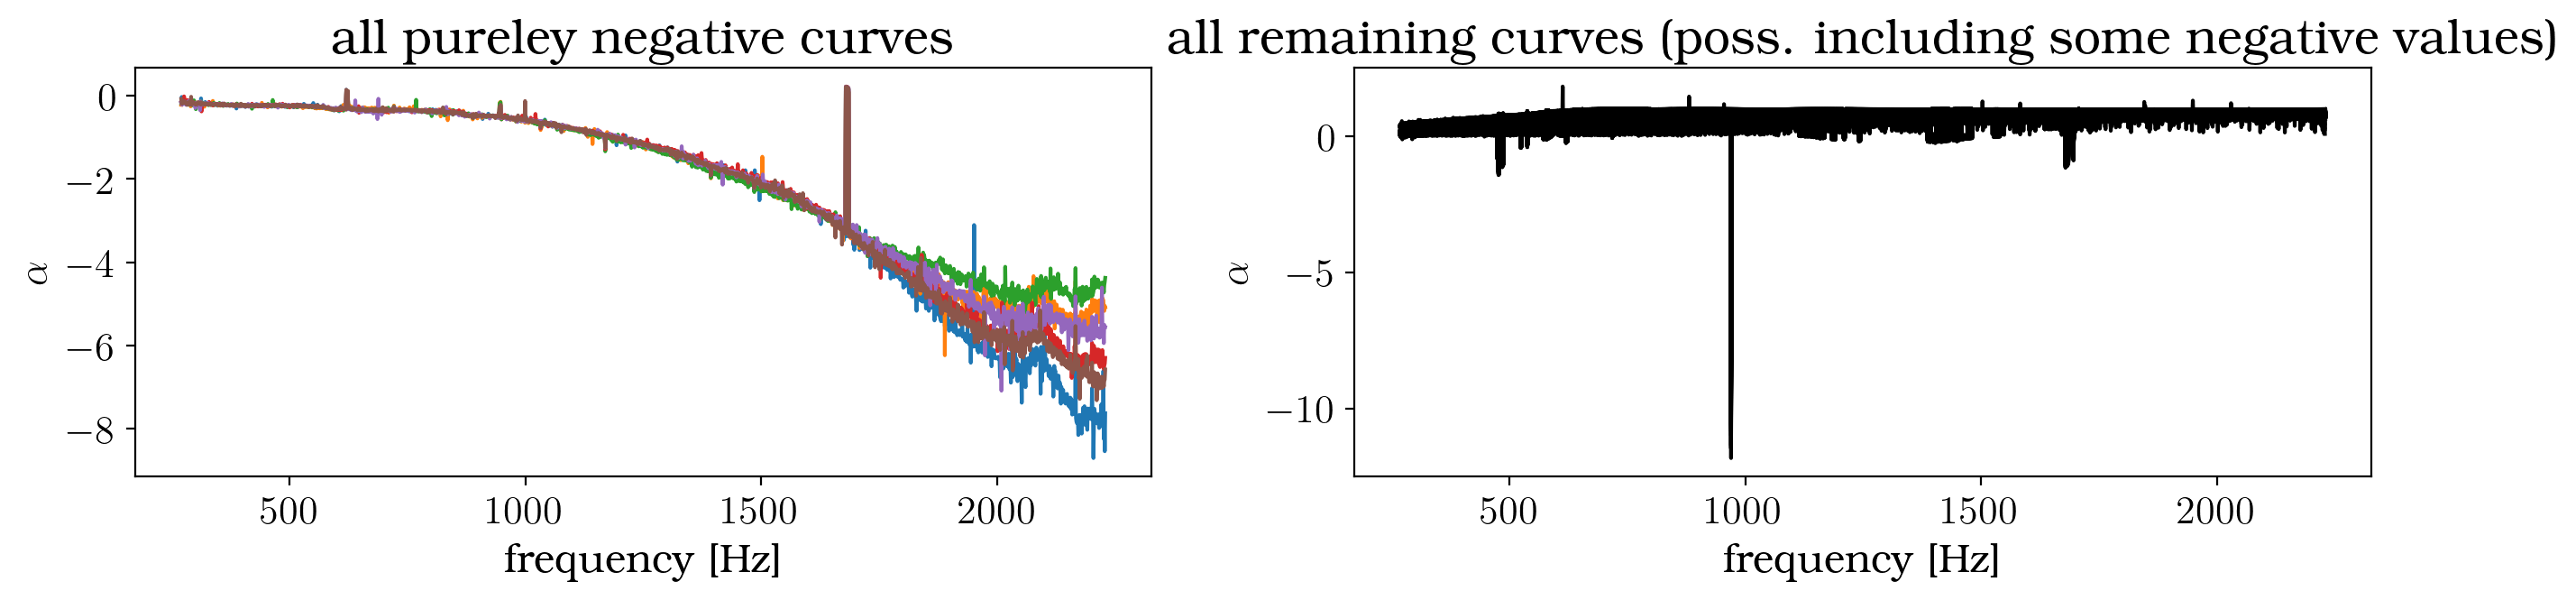

shape of non-negative data: (3073, 1960)


In [17]:
# there are some absorption curves that are commpletely negative. We'll remove them
mins = np.mean(alpha, axis=1)  # find indices of the all-negatives

# plot them (just for illustrative purposes)
plt.figure(num=None, figsize=(16, 3), dpi=200, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(f, alpha[mins<0.0,:].transpose())
plt.xlabel('frequency [Hz]')
plt.ylabel(r'$\alpha$')
plt.title('all pureley negative curves')

plt.subplot(1,2,2)
plt.plot(f, alpha[mins>=0.0,:].transpose(), color='k')
plt.xlabel('frequency [Hz]')
plt.ylabel(r'$\alpha$')
plt.title('all remaining curves (poss. including some negative values)')
plt.show()

# remove the all-negative samples
alpha = alpha[mins>0.0,:]
factors = factors[:][mins>0.0]
print('shape of non-negative data: ' + str(alpha.shape))

#### 2. filter local negative absorption values

There are some negative values in between (sudden drops). Their root cause is still unclear, but we'll remove them

In [18]:
# replace all negative entries with some small value (0.01)
alpha_pos = result = np.where(alpha<0, 0.01, alpha)

#### 3. inpaint through rolling window processing

1. rolling median of length 25
2. rolling maximum of length 50

In [19]:
# now fill in the current drops by rolling median and consecutive rolling max
alpha_smooth_med = np.array(pd.DataFrame(alpha_pos).rolling(window=25, center=True, min_periods=1, axis=1).median())
alpha_smooth_max = np.array(pd.DataFrame(alpha_smooth_med).rolling(window=50, center=True, min_periods=1, axis=1).max())

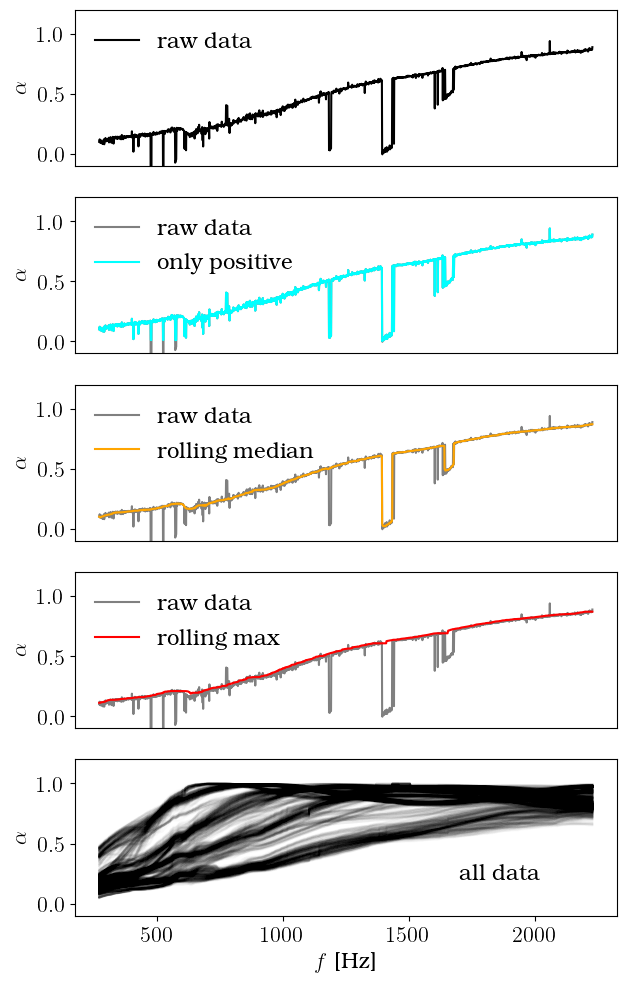

In [20]:
# plot some representative sample
idx = 354  # 20, 354 are good ones

from matplotlib import rc
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})
rc('font',**{'family':'serif','serif':['Bookman']})
rc('text', usetex=True)

plt.figure(num=None, figsize=(7, 12), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(5,1,1)
plt.plot(f, alpha[idx,:], color='k', label='raw data')  
plt.ylim([-0.1, 1.2])
plt.xticks([])
plt.legend(frameon=False)
plt.ylabel(r'$\alpha$')

plt.subplot(5,1,2)
plt.plot(f, alpha[idx,:], color='gray', label='raw data') 
plt.plot(f, alpha_pos[idx,:], color='cyan', label='only positive')
plt.ylim([-0.1, 1.2])
plt.legend(frameon=False)
plt.ylabel(r'$\alpha$')
plt.xticks([])

plt.subplot(5,1,3)
plt.plot(f, alpha[idx,:], color='gray', label='raw data')
plt.plot(f, alpha_smooth_med[idx,:], color='orange', label='rolling median')
plt.ylim([-0.1, 1.2])
plt.legend(frameon=False)
plt.ylabel(r'$\alpha$')
plt.xticks([])

plt.subplot(5,1,4)
plt.plot(f, alpha[idx,:], color='gray', label='raw data')
plt.plot(f, alpha_smooth_max[idx,:], color='red', label='rolling max')
plt.ylim([-0.1, 1.2])
plt.legend(frameon=False)
plt.ylabel(r'$\alpha$')
plt.xticks([])

plt.subplot(5,1,5)
plt.plot(f, alpha_smooth_max.transpose(), color='k', alpha=0.01)
plt.ylim([-0.1, 1.2])
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\alpha$')
# plt.title('all data, final')
plt.text(1700, 0.2, 'all data')
plt.savefig('data_cleaning.png') 
plt.savefig('data_cleaning.pdf', bbox_inches='tight') 
plt.show()

### Downsampling (if requested by the user)

number of measurements: 3073
number of frequency points: 196


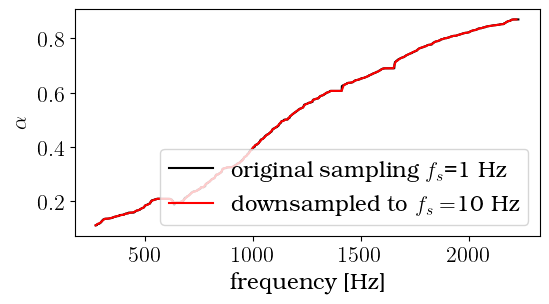

In [21]:
n_sampling = 1960/10  # define the new samplig rate by the number of frequency points

# downsampling
m = int(len(f)/n_sampling)
f_coarse = f[::m]  # pick each mth element
alpha_coarse = alpha_smooth_max[:, ::m]  # pick each mth element

n_observations = alpha_coarse.shape[0]
n_inputs  = len(f_coarse)
print('number of measurements: ' + str(n_observations))
print('number of frequency points: ' + str(n_inputs))


plt.figure(figsize=(6,3), dpi=100)
plt.plot(f, alpha_smooth_max[idx,:], color='k', label='original sampling $f_s$=1 Hz')
plt.plot(f_coarse, alpha_coarse[idx,:], color='r', label='downsampled to $f_s=$' + str(m) + ' Hz')
plt.ylabel(r'$\alpha$')
plt.xlabel('frequency [Hz]')
plt.legend()
plt.show()
    

## display the complete (cleaned) data set

study the mean, max. differences and standard deviation at each frequency

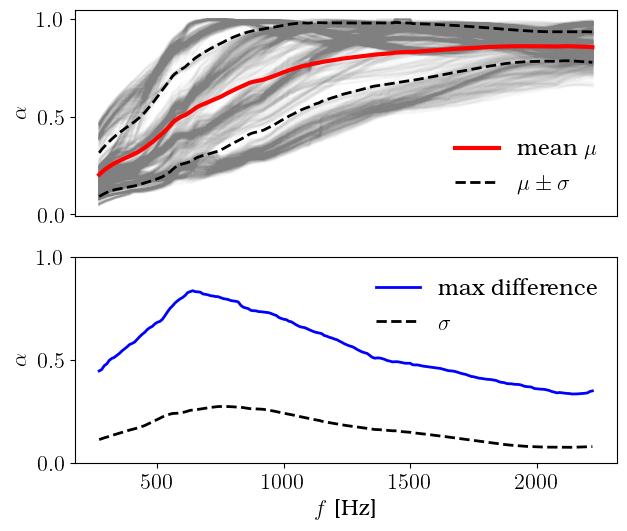

In [22]:
# first, let's compute some summary statistics per frequency value
mins = np.min(alpha_coarse, axis=0)
maxs = np.max(alpha_coarse, axis=0)
means = np.mean(alpha_coarse, axis=0)
stds = np.std(alpha_coarse, axis=0)
medians = np.median(alpha_coarse, axis=0)

from matplotlib import rc
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})
rc('font',**{'family':'serif','serif':['Bookman']})
rc('text', usetex=True)

plt.figure(num=None, figsize=(7, 6), dpi=100, facecolor='w')
plt.subplot(2,1,1)
plt.plot(f_coarse, alpha_coarse.transpose(), color='gray', alpha=0.01)
plt.plot(f_coarse, means, color='red', linewidth=3, label='mean $\mu$')
plt.plot(f_coarse, means+stds, color='k', linewidth=2, linestyle='dashed', label='$\mu \pm \sigma$')
plt.plot(f_coarse, means-stds, color='k', linewidth=2, linestyle='dashed')
# plt.xlabel('frequency [Hz]')
plt.xticks([])
plt.yticks([0, 0.5, 1.0])
plt.ylabel(r'$\alpha$')
plt.legend(frameon=False)

plt.subplot(2,1,2)
plt.plot(f_coarse, np.abs(maxs-mins),color='b', label='max difference', linewidth=2)
plt.plot(f_coarse, stds ,color='k', linestyle='--', label='$\sigma$', linewidth=2)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\alpha$')
plt.yticks([0, 0.5, 1.0])
plt.legend(frameon=False)
plt.savefig('data_distribution.png') 
plt.savefig('data_distribution.pdf', bbox_inches='tight') 
plt.show()

## Summary 

For Table II in the manuscript: display the number of samples per class

In [23]:
print('Number of samples: N = ' + str(factors.shape[0]))
print('Number of samples per class:')
print(factors.sum())


Number of samples: N = 3073
Number of samples per class:
30mm              768
40mm              768
50mm              769
80mm              768
89mm             1008
90mm             1040
91mm             1025
HZD               211
MES                66
SLF               642
SLH               648
SSF               648
SSH               642
WSS               216
plunger_fixed    1536
plunger_moved    1537
computer          427
person1           930
person2           852
person3           864
dtype: int64
